# Github

https://github.com/yhuang0701/Context-aware-Health-Event-Prediction-via-Transition-Functions-on-Dynamic-Disease-Graphs

# Mount Notebook to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


# Introduction


* Chang Lu, Tian Han, and Yue Ning present a groundbreaking approach to predicting health events using electronic health records (EHRs) in a paper titled "Context-Aware Health Eve
nt Prediction via Transformation Functions on Dynamic Disease Maps." This research addresses the shortcomings of existing health prediction models that typically treat diseases as static and isolated entities. Instead, it proposes a model that views diseases dynamically and interconnects them, thereby greatly improving the prediction of health events.

* The main contributions of this research include the development of a context-aware learning framework that incorporates transition functions on a dynamic disease graph. The framework consists of constructing a global disease co-occurrence graph to model the interactions of various diseases over time, supplemented with dynamic subgraphs for each patient visit. These subgraphs reflect both the overall disease interactions and the specific history of the patient, allowing for a comprehensive and detailed analysis of disease progression.

* In addition, the model introduces a transition function that divides the diagnosis into three roles: persistent disease, emerging neighboring disease, and emerging unrelated disease. These roles help to simulate the process of disease transition, and by utilizing both historical and current health data, the predictive accuracy of the model is greatly improved.

* The utility and effectiveness of this innovative approach is demonstrated through extensive experiments using real-world electronic medical record datasets, which show superior performance in predicting health events compared to existing state-of-the-art models. This success highlights the framework's ability to deal with the dynamic nature of disease progression and underscores its potential to revolutionize prediction methods in healthcare settings.

* In summary, this research significantly advances the field of health event prediction by employing advanced graph theory and machine learning techniques. Such dynamic and context-aware models not only improve prediction accuracy, but also enhance the understanding of complex disease interaction patterns, paving the way for improved clinical decision-making and personalized patient care.

# Scope of Reproducibility:


## Hypothesis 1:  Dynamic disease maps improve prediction accuracy more than static models.

To test this hypothesis, we will replicate the experiments conducted in the original study using the provided EHR dataset. We will compare the performance of the proposed dynamic graph model with a baseline model that treats disease data as static (e.g., a traditional machine learning model without temporal or relational context).

## Hypothesis 2: Increasing the dropout rate in the model will improve its generalization on the validation set by reducing overfitting.
To address this hypothesis, we will design experiments to modify these rates, run the model, and compare the performance in terms of loss, F1-score, and other relevant metrics.

# Methodology

The methodology section of our reproducibility study aims to rigorously test the hypotheses presented in the original paper, "Context-aware health event prediction via transformation functions on dynamic disease maps." This section is organized into five sections: environment, data, model, training, and evaluation. Each section includes comprehensive details and runnable code, as well as annotations needed to replicate the experiments and validate the original research statement.

## Environment




Below is the environment the original paper mentioned. (This is also mentioned in the original paper's github repo, and stored in the reuirements.txt):



```
joblib==1.0.1
numpy==1.20.2
pandas==1.2.3
Pillow==8.2.0
python-dateutil==2.8.1
pytz==2021.1
scikit-learn==0.24.1
scipy==1.6.2
six==1.15.0
threadpoolctl==2.1.0
torch==1.8.1+cu111
torchaudio==0.8.1
torchvision==0.9.1+cu111
typing-extensions==3.7.4.3
```

For Google Colab, we simply can run all codes without setup the environment.

The next cell is the command to setup the environment on Google Colab (if needed).

In [ ]:
# !pip install -r '/content/drive/MyDrive/CS598HLO/Chet/requirements.txt'

## Data

### Source of the Data

The data we used in this experiment is the MIMIC-III Clinical Database Dataset which could be found here: https://physionet.org/content/mimiciii/1.4/.

This detaset needs to gain credentials before use, more detailed instructions on how to gain access of the dataset is on their official website.

Specifically, we only need to use the ADMISSIONS.csv and DIAGNOSES_ICD.csv dataset in this project.

**Once you have the authority for the dataset, download the dataset and extract the csv files to data/mimic3/raw/ in the file location you cloned from the original github repo: (https://github.com/luchang-cs/chet)**

Note: In the original paper, the authors choose to use the MIMIC-III and MIMIC-IV dataset. In our project, we only focused on experiments with MIMIC-III dataset.

### MIMIC-III Dataset Description

MIMIC-III is a relational database consisting of 26 tables. Tables are linked by identifiers which usually have the suffix ‘ID’. For example, SUBJECT_ID refers to a unique patient, HADM_ID refers to a unique admission to the hospital, and ICUSTAY_ID refers to a unique admission to an intensive care unit.

Broadly speaking, five tables are used to define and track patient stays: ADMISSIONS; PATIENTS; ICUSTAYS; SERVICES; and TRANSFERS. Another five tables are dictionaries for cross-referencing codes against their respective definitions: D_CPT; D_ICD_DIAGNOSES; D_ICD_PROCEDURES; D_ITEMS; and D_LABITEMS. The remaining tables contain data associated with patient care, such as physiological measurements, caregiver observations, and billing information.

Below is the statistical information of MIMIC-III and MIMIC-IV dataset:

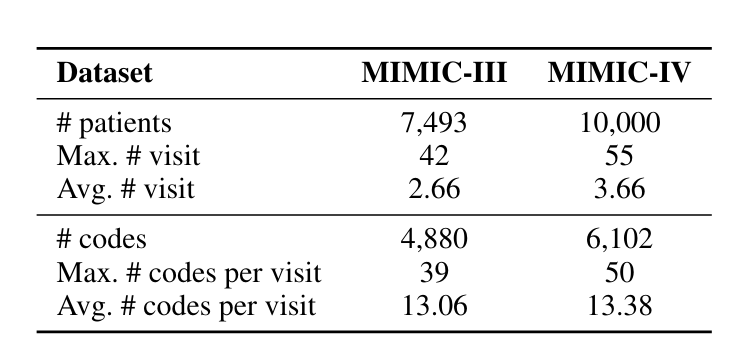

### Data Preprocess:



The original paper built three different kind of graph based on the dataset:

**Local diagnosis graph $G^t_D$**. It is a complete graph consisting of diagnoses in visit $t$. We use an adjacency matrix $M^t \in \mathbb{R}^{d \times d}$ to represent $G^t_D$. $M^t_{ij} = A_{ij}$ if $c_i$ and $c_j$ are diagnosed in visit $t$. Otherwise $M^t_{ij} = 0$.

**Global diagnosis-neighbor graph $G^t_{DN}$**. It is a bipartite graph describing the connection of diagnoses in visit $t$ and their neighbors (connected diseases but not diagnosis in visit $t$) in $G$. We use an adjacency matrix $B^t \in \mathbb{R}^{d \times d}$ to represent connections from diagnoses to neighbors. $B^t_{ij} = A_{ij}$ if $c_i$ is diagnosed in visit $t$ and $c_j$ is a neighbor of $c_i$ in $G$ and $c_j$ is not diagnosed in visit $t$. Otherwise $B^t_{ij} = 0$. For opposite connections, since $A$ is asymmetric, the transpose of $B^t$ cannot be used. We use another matrix $\tilde{B}^t$ instead to denote neighbor-diagnosis edges. It is calculated in a similar manner to $B^t_{ij}$.

**Global neighbor graph $G^t_N$**. It is a graph for neighbors in visit $t$. We use an adjacency matrix $N^t \in \mathbb{R}^{d \times d}$ to represent $G^t_N$. $N^t_{ij} = A_{ij}$ if $c_i$ and $c_j$ are two neighbors and are not diagnosed in visit $t$. Otherwise $N^t_{ij} = 0$.



Below is the preprocess code to construct the graphs and split the dataset to train/valid/test set:

In [2]:
!cp -r '/content/drive/MyDrive/CS598HLO/Chet/preprocess' .

In [3]:
import os
import pickle
from preprocess import save_sparse, save_data
from preprocess.parse_csv import Mimic3Parser, Mimic4Parser, EICUParser
from preprocess.encode import encode_code
from preprocess.build_dataset import split_patients, build_code_xy, build_heart_failure_y
from preprocess.auxiliary import generate_code_code_adjacent, generate_neighbors, normalize_adj, divide_middle, generate_code_levels


conf = {
      'mimic3': {
          'parser': Mimic3Parser,
          'train_num': 6000,
          'test_num': 1000,
          'threshold': 0.01
      },
      'mimic4': {
          'parser': Mimic4Parser,
          'train_num': 8000,
          'test_num': 1000,
          'threshold': 0.01,
          'sample_num': 10000
      },
      'eicu': {
          'parser': EICUParser,
          'train_num': 8000,
          'test_num': 1000,
          'threshold': 0.01
      }
  }
from_saved = False
data_path = '/content/drive/MyDrive/CS598HLO/Chet/data/'
dataset = 'mimic3'  # mimic3, eicu, or mimic4
dataset_path = os.path.join(data_path, dataset)
raw_path = os.path.join(dataset_path, 'raw')
if not os.path.exists(raw_path):
    os.makedirs(raw_path)
    print('please put the CSV files in `data/%s/raw`' % dataset)
    exit()
parsed_path = os.path.join(dataset_path, 'parsed')
if from_saved:
    patient_admission = pickle.load(open(os.path.join(parsed_path, 'patient_admission.pkl'), 'rb'))
    admission_codes = pickle.load(open(os.path.join(parsed_path, 'admission_codes.pkl'), 'rb'))
else:
    parser = conf[dataset]['parser'](raw_path)
    sample_num = conf[dataset].get('sample_num', None)
    patient_admission, admission_codes = parser.parse(sample_num)
    print('saving parsed data ...')
    if not os.path.exists(parsed_path):
        os.makedirs(parsed_path)
    pickle.dump(patient_admission, open(os.path.join(parsed_path, 'patient_admission.pkl'), 'wb'))
    pickle.dump(admission_codes, open(os.path.join(parsed_path, 'admission_codes.pkl'), 'wb'))

patient_num = len(patient_admission)
max_admission_num = max([len(admissions) for admissions in patient_admission.values()])
avg_admission_num = sum([len(admissions) for admissions in patient_admission.values()]) / patient_num
max_visit_code_num = max([len(codes) for codes in admission_codes.values()])
avg_visit_code_num = sum([len(codes) for codes in admission_codes.values()]) / len(admission_codes)
print('patient num: %d' % patient_num)
print('max admission num: %d' % max_admission_num)
print('mean admission num: %.2f' % avg_admission_num)
print('max code num in an admission: %d' % max_visit_code_num)
print('mean code num in an admission: %.2f' % avg_visit_code_num)

print('encoding code ...')
admission_codes_encoded, code_map = encode_code(patient_admission, admission_codes)
code_num = len(code_map)
print('There are %d codes' % code_num)

code_levels = generate_code_levels(data_path, code_map)
pickle.dump({
    'code_levels': code_levels,
}, open(os.path.join(parsed_path, 'code_levels.pkl'), 'wb'))

train_pids, valid_pids, test_pids = split_patients(
    patient_admission=patient_admission,
    admission_codes=admission_codes,
    code_map=code_map,
    train_num=conf[dataset]['train_num'],
    test_num=conf[dataset]['test_num']
)
print('There are %d train, %d valid, %d test samples' % (len(train_pids), len(valid_pids), len(test_pids)))
code_adj = generate_code_code_adjacent(pids=train_pids, patient_admission=patient_admission,
                                        admission_codes_encoded=admission_codes_encoded,
                                        code_num=code_num, threshold=conf[dataset]['threshold'])

common_args = [patient_admission, admission_codes_encoded, max_admission_num, code_num]
print('building train codes features and labels ...')
(train_code_x, train_codes_y, train_visit_lens) = build_code_xy(train_pids, *common_args)
print('building valid codes features and labels ...')
(valid_code_x, valid_codes_y, valid_visit_lens) = build_code_xy(valid_pids, *common_args)
print('building test codes features and labels ...')
(test_code_x, test_codes_y, test_visit_lens) = build_code_xy(test_pids, *common_args)

print('generating train neighbors ...')
train_neighbors = generate_neighbors(train_code_x, train_visit_lens, code_adj)
print('generating valid neighbors ...')
valid_neighbors = generate_neighbors(valid_code_x, valid_visit_lens, code_adj)
print('generating test neighbors ...')
test_neighbors = generate_neighbors(test_code_x, test_visit_lens, code_adj)

print('generating train middles ...')
train_divided = divide_middle(train_code_x, train_neighbors, train_visit_lens)
print('generating valid middles ...')
valid_divided = divide_middle(valid_code_x, valid_neighbors, valid_visit_lens)
print('generating test middles ...')
test_divided = divide_middle(test_code_x, test_neighbors, test_visit_lens)

print('building train heart failure labels ...')
train_hf_y = build_heart_failure_y('428', train_codes_y, code_map)
print('building valid heart failure labels ...')
valid_hf_y = build_heart_failure_y('428', valid_codes_y, code_map)
print('building test heart failure labels ...')
test_hf_y = build_heart_failure_y('428', test_codes_y, code_map)

encoded_path = os.path.join(dataset_path, 'encoded')
if not os.path.exists(encoded_path):
    os.makedirs(encoded_path)
print('saving encoded data ...')
pickle.dump(patient_admission, open(os.path.join(encoded_path, 'patient_admission.pkl'), 'wb'))
pickle.dump(admission_codes_encoded, open(os.path.join(encoded_path, 'codes_encoded.pkl'), 'wb'))
pickle.dump(code_map, open(os.path.join(encoded_path, 'code_map.pkl'), 'wb'))
pickle.dump({
    'train_pids': train_pids,
    'valid_pids': valid_pids,
    'test_pids': test_pids
}, open(os.path.join(encoded_path, 'pids.pkl'), 'wb'))

print('saving standard data ...')
standard_path = os.path.join(dataset_path, 'standard')
train_path = os.path.join(standard_path, 'train')
valid_path = os.path.join(standard_path, 'valid')
test_path = os.path.join(standard_path, 'test')
if not os.path.exists(standard_path):
    os.makedirs(standard_path)
if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(valid_path)
    os.makedirs(test_path)

print('\tsaving training data')
save_data(train_path, train_code_x, train_visit_lens, train_codes_y, train_hf_y, train_divided, train_neighbors)
print('\tsaving valid data')
save_data(valid_path, valid_code_x, valid_visit_lens, valid_codes_y, valid_hf_y, valid_divided, valid_neighbors)
print('\tsaving test data')
save_data(test_path, test_code_x, test_visit_lens, test_codes_y, test_hf_y, test_divided, test_neighbors)

code_adj = normalize_adj(code_adj)
save_sparse(os.path.join(standard_path, 'code_adj'), code_adj)


parsing the csv file of admission ...
	58976 in 58976 rows
parsing csv file of diagnosis ...
	651047 in 651047 rows
calibrating patients by admission ...
calibrating admission by patients ...
saving parsed data ...
patient num: 7493
max admission num: 42
mean admission num: 2.66
max code num in an admission: 39
mean code num in an admission: 13.06
encoding code ...
There are 4880 codes
generating code levels ...
	100%
There are 6000 train, 493 valid, 1000 test samples
generating code code adjacent matrix ...
	6000 / 6000
building train codes features and labels ...
	6000 / 6000
building valid codes features and labels ...
	493 / 493
building test codes features and labels ...
	1000 / 1000
generating train neighbors ...
	6000 / 6000
generating valid neighbors ...
	493 / 493
generating test neighbors ...
	1000 / 1000
generating train middles ...
	6000 / 6000
generating valid middles ...
	493 / 493
generating test middles ...
	1000 / 1000
building train heart failure labels ...
building v

### Statistics
The MIMIC-III dataset containes 7493 patient records. Running the above proprocessing pipeline will split the dataset to train/val/test set with choices of 6000/493/1000, respectively.

In summary, the dataset statistic is:

* patient num: 7493
* max admission num: 42
* mean admission num: 2.66
* max code num in an admission: 39
* mean code num in an admission: 13.06

For the heart failure labels, we choose 1 for having this discase, and 0 for not having this disease.

##   Model

### Citation

Lu, C., Han, T., & Ning, Y. (2021). Context-aware Health Event Prediction via Transition Functions on Dynamic Disease Graphs. ArXiv. /abs/2112.05195

Github Repo: (https://github.com/luchang-cs/chet)

### Model Description



* Architecture: The proposed model, Chet, uses a novel context-aware learning framework that utilizes dynamic graphs constructed from patient Electronic Health Record (EHR) data to predict health events. The model architecture includes:

  * **Global Disease Combination Graph**: A weighted graph with nodes representing disease combinations derived from historical diagnosis data.
  * **Dynamic Subgraphs**: For each patient visit, dynamic subgraphs are created to represent local and global contexts involving the diseases diagnosed in that visit.
  * **Graph Neural Network (GNN)**: Used to learn from the dynamic graphs, integrating both the local context of a visit and the global context from historical data.
  * **Transition Functions**: Defined for various diagnosis roles to model the disease transition process across different visits.

* Activation Function: The model uses the **LeakyReLU** activation function in its graph neural network layers to manage non-linearity.

* Training Objectives:
  * Loss Function: **Binary Cross-Entropy** loss is used for training, suitable for the multi-label classification tasks such as predicting multiple medical diagnoses.
  * Optimizer: The **Adam optimizer** is employed to minimize the loss function, facilitating efficient convergence.

### Implementation Code

Below is the model implementation code:

In [4]:
import math

import torch
from torch import nn

In [5]:
class SingleHeadAttentionLayer(nn.Module):
    def __init__(self, query_size, key_size, value_size, attention_size):
        super().__init__()
        self.attention_size = attention_size
        self.dense_q = nn.Linear(query_size, attention_size)
        self.dense_k = nn.Linear(key_size, attention_size)
        self.dense_v = nn.Linear(query_size, value_size)

    def forward(self, q, k, v):
        query = self.dense_q(q)
        key = self.dense_k(k)
        value = self.dense_v(v)
        g = torch.div(torch.matmul(query, key.T), math.sqrt(self.attention_size))
        score = torch.softmax(g, dim=-1)
        output = torch.sum(torch.unsqueeze(score, dim=-1) * value, dim=-2)
        return output


class DotProductAttention(nn.Module):
    def __init__(self, value_size, attention_size):
        super().__init__()
        self.attention_size = attention_size
        self.context = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(attention_size, 1)))
        self.dense = nn.Linear(value_size, attention_size)

    def forward(self, x):
        t = self.dense(x)
        vu = torch.matmul(t, self.context).squeeze()
        score = torch.softmax(vu, dim=-1)
        output = torch.sum(x * torch.unsqueeze(score, dim=-1), dim=-2)
        return output


In [6]:
class EmbeddingLayer(nn.Module):
    def __init__(self, code_num, code_size, graph_size):
        super().__init__()
        self.code_num = code_num
        self.c_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        self.n_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, code_size)))
        self.u_embeddings = nn.Parameter(data=nn.init.xavier_uniform_(torch.empty(code_num, graph_size)))

    def forward(self):
        return self.c_embeddings, self.n_embeddings, self.u_embeddings


class GraphLayer(nn.Module):
    def __init__(self, adj, code_size, graph_size):
        super().__init__()
        self.adj = adj
        self.dense = nn.Linear(code_size, graph_size)
        self.activation = nn.LeakyReLU()

    def forward(self, code_x, neighbor, c_embeddings, n_embeddings):
        center_codes = torch.unsqueeze(code_x, dim=-1)
        neighbor_codes = torch.unsqueeze(neighbor, dim=-1)

        center_embeddings = center_codes * c_embeddings
        neighbor_embeddings = neighbor_codes * n_embeddings
        cc_embeddings = center_codes * torch.matmul(self.adj, center_embeddings)
        cn_embeddings = center_codes * torch.matmul(self.adj, neighbor_embeddings)
        nn_embeddings = neighbor_codes * torch.matmul(self.adj, neighbor_embeddings)
        nc_embeddings = neighbor_codes * torch.matmul(self.adj, center_embeddings)

        co_embeddings = self.activation(self.dense(center_embeddings + cc_embeddings + cn_embeddings))
        no_embeddings = self.activation(self.dense(neighbor_embeddings + nn_embeddings + nc_embeddings))
        return co_embeddings, no_embeddings


class TransitionLayer(nn.Module):
    def __init__(self, code_num, graph_size, hidden_size, t_attention_size, t_output_size):
        super().__init__()
        self.gru = nn.GRUCell(input_size=graph_size, hidden_size=hidden_size)
        self.single_head_attention = SingleHeadAttentionLayer(graph_size, graph_size, t_output_size, t_attention_size)
        self.activation = nn.Tanh()

        self.code_num = code_num
        self.hidden_size = hidden_size

    def forward(self, t, co_embeddings, divided, no_embeddings, unrelated_embeddings, hidden_state=None):
        m1, m2, m3 = divided[:, 0], divided[:, 1], divided[:, 2]
        m1_index = torch.where(m1 > 0)[0]
        m2_index = torch.where(m2 > 0)[0]
        m3_index = torch.where(m3 > 0)[0]
        h_new = torch.zeros((self.code_num, self.hidden_size), dtype=co_embeddings.dtype).to(co_embeddings.device)
        output_m1 = 0
        output_m23 = 0
        if len(m1_index) > 0:
            m1_embedding = co_embeddings[m1_index]
            h = hidden_state[m1_index] if hidden_state is not None else None
            h_m1 = self.gru(m1_embedding, h)
            h_new[m1_index] = h_m1
            output_m1, _ = torch.max(h_m1, dim=-2)
        if t > 0 and len(m2_index) + len(m3_index) > 0:
            q = torch.vstack([no_embeddings[m2_index], unrelated_embeddings[m3_index]])
            v = torch.vstack([co_embeddings[m2_index], co_embeddings[m3_index]])
            h_m23 = self.activation(self.single_head_attention(q, q, v))
            h_new[m2_index] = h_m23[:len(m2_index)]
            h_new[m3_index] = h_m23[len(m2_index):]
            output_m23, _ = torch.max(h_m23, dim=-2)
        if len(m1_index) == 0:
            output = output_m23
        elif len(m2_index) + len(m3_index) == 0:
            output = output_m1
        else:
            output, _ = torch.max(torch.vstack([output_m1, output_m23]), dim=-2)
        return output, h_new

In [7]:
class Classifier(nn.Module):
    def __init__(self, input_size, output_size, dropout_rate=0., activation=None):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.activation = activation
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        output = self.dropout(x)
        output = self.linear(output)
        if self.activation is not None:
            output = self.activation(output)
        return output


class Model(nn.Module):
    def __init__(self, code_num, code_size,
                 adj, graph_size, hidden_size, t_attention_size, t_output_size,
                 output_size, dropout_rate, activation):
        super().__init__()
        self.embedding_layer = EmbeddingLayer(code_num, code_size, graph_size)
        self.graph_layer = GraphLayer(adj, code_size, graph_size)
        self.transition_layer = TransitionLayer(code_num, graph_size, hidden_size, t_attention_size, t_output_size)
        self.attention = DotProductAttention(hidden_size, 32)
        self.classifier = Classifier(hidden_size, output_size, dropout_rate, activation)

    def forward(self, code_x, divided, neighbors, lens):
        embeddings = self.embedding_layer()
        c_embeddings, n_embeddings, u_embeddings = embeddings
        output = []
        for code_x_i, divided_i, neighbor_i, len_i in zip(code_x, divided, neighbors, lens):
            no_embeddings_i_prev = None
            output_i = []
            h_t = None
            for t, (c_it, d_it, n_it, len_it) in enumerate(zip(code_x_i, divided_i, neighbor_i, range(len_i))):
                co_embeddings, no_embeddings = self.graph_layer(c_it, n_it, c_embeddings, n_embeddings)
                output_it, h_t = self.transition_layer(t, co_embeddings, d_it, no_embeddings_i_prev, u_embeddings, h_t)
                no_embeddings_i_prev = no_embeddings
                output_i.append(output_it)
            output_i = self.attention(torch.vstack(output_i))
            output.append(output_i)
        output = torch.vstack(output)
        output = self.classifier(output)
        return output

## Training

### Hyperparams

The hyperparameters used in this training procedure is:



```
code_size = 48
graph_size = 32
hidden_size = 150  # rnn hidden size
t_attention_size = 32
t_output_size = hidden_size
batch_size = 32
epochs = 200
```

### Computational Requirements

**Hardware**:
  * In the original paper, they mentioned they trained all code using a machine with Intel i9-9900K CPU, 64GB memory, and
Geforce RTX 2080 Ti GPU.
  * In our project, we use Google Colab for running all codes and experiements.

**Average runtime for each epoch**: runtime roughly 1 minute and 30 seconds per epoch (using T4 GPU in Google Colab).

**Number of training epochs**: 200 epochs for original paper's implementation. For our project, we use 50 epochs to demonstate the result.

**The reason we choose to use 50 epochs instead of 200 is because we observed that the model converges to a point after 20 epochs. Please see Results part for the detailed discussion.**


### Training Code

#### Utils Code Before Training

In [8]:
from preprocess import load_sparse

def load_adj(path, device=torch.device('cpu')):
    filename = os.path.join(path, 'code_adj.npz')
    adj = torch.from_numpy(load_sparse(filename)).to(device=device, dtype=torch.float32)
    return adj


class EHRDataset:
    def __init__(self, data_path, label='m', batch_size=32, shuffle=True, device=torch.device('cpu')):
        super().__init__()
        self.path = data_path
        self.code_x, self.visit_lens, self.y, self.divided, self.neighbors = self._load(label)

        self._size = self.code_x.shape[0]
        self.idx = np.arange(self._size)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.device = device

    def _load(self, label):
        code_x = load_sparse(os.path.join(self.path, 'code_x.npz'))
        visit_lens = np.load(os.path.join(self.path, 'visit_lens.npz'))['lens']
        if label == 'm':
            y = load_sparse(os.path.join(self.path, 'code_y.npz'))
        elif label == 'h':
            y = np.load(os.path.join(self.path, 'hf_y.npz'))['hf_y']
        else:
            raise KeyError('Unsupported label type')
        divided = load_sparse(os.path.join(self.path, 'divided.npz'))
        neighbors = load_sparse(os.path.join(self.path, 'neighbors.npz'))
        return code_x, visit_lens, y, divided, neighbors

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.idx)

    def size(self):
        return self._size

    def label(self):
        return self.y

    def __len__(self):
        len_ = self._size // self.batch_size
        return len_ if self._size % self.batch_size == 0 else len_ + 1

    def __getitem__(self, index):
        device = self.device
        start = index * self.batch_size
        end = start + self.batch_size
        slices = self.idx[start:end]
        code_x = torch.from_numpy(self.code_x[slices]).to(device)
        visit_lens = torch.from_numpy(self.visit_lens[slices]).to(device=device, dtype=torch.long)
        y = torch.from_numpy(self.y[slices]).to(device=device, dtype=torch.float32)
        divided = torch.from_numpy(self.divided[slices]).to(device)
        neighbors = torch.from_numpy(self.neighbors[slices]).to(device)
        return code_x, visit_lens, divided, y, neighbors


class MultiStepLRScheduler:
    def __init__(self, optimizer, epochs, init_lr, milestones, lrs):
        self.optimizer = optimizer
        self.epochs = epochs
        self.init_lr = init_lr
        self.lrs = self._generate_lr(milestones, lrs)
        self.current_epoch = 0

    def _generate_lr(self, milestones, lrs):
        milestones = [1] + milestones + [self.epochs + 1]
        lrs = [self.init_lr] + lrs
        lr_grouped = np.concatenate([np.ones((milestones[i + 1] - milestones[i], )) * lrs[i]
                                     for i in range(len(milestones) - 1)])
        return lr_grouped

    def step(self):
        lr = self.lrs[self.current_epoch]
        for group in self.optimizer.param_groups:
            group['lr'] = lr
        self.current_epoch += 1

    def reset(self):
        self.current_epoch = 0


def format_time(seconds):
    if seconds <= 60:
        time_str = '%.1fs' % seconds
    elif seconds <= 3600:
        time_str = '%dm%.1fs' % (seconds // 60, seconds % 60)
    else:
        time_str = '%dh%dm%.1fs' % (seconds // 3600, (seconds % 3600) // 60, seconds % 60)
    return time_str

#### Training Code

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/CS598HLO/Chet')


In [13]:
import os
import random
import time

import torch
import numpy as np

from models.model import Model
from utils import load_adj, EHRDataset, format_time, MultiStepLRScheduler
from metrics import evaluate_codes, evaluate_hf


def historical_hot(code_x, code_num, lens):
    result = np.zeros((len(code_x), code_num), dtype=int)
    for i, (x, l) in enumerate(zip(code_x, lens)):
        result[i] = x[l - 1]
    return result


if __name__ == '__main__':
    seed = 6669
    dataset = 'mimic3'  # 'mimic3' or 'eicu'
    task = 'h'  # 'm' or 'h'
    use_cuda = True
    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')

    code_size = 48
    graph_size = 32
    hidden_size = 150  # rnn hidden size
    t_attention_size = 32
    t_output_size = hidden_size
    batch_size = 32
    epochs = 50

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # dataset_path = os.path.join('data', dataset, 'standard')
    dataset_path = '/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard'
    print(dataset_path)
    train_path = os.path.join(dataset_path, 'train')

    valid_path = os.path.join(dataset_path, 'valid')
    test_path = os.path.join(dataset_path, 'test')

    # dataset_path = '/content/drive/MyDrive/Colab Notebooks/Chet/data/mimic3/standard/code_adj.npz'

    code_adj = load_adj(dataset_path, device=device)
    code_num = len(code_adj)
    print('loading train data ...')
    train_data = EHRDataset(train_path, label=task, batch_size=batch_size, shuffle=True, device=device)
    print('loading valid data ...')
    valid_data = EHRDataset(valid_path, label=task, batch_size=batch_size, shuffle=False, device=device)
    print('loading test data ...')
    test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)

    test_historical = historical_hot(valid_data.code_x, code_num, valid_data.visit_lens)

    task_conf = {
        'm': {
            'dropout': 0.45,
            'output_size': code_num,
            'evaluate_fn': evaluate_codes,
            'lr': {
                'init_lr': 0.01,
                'milestones': [20, 30],
                'lrs': [1e-3, 1e-5]
            }
        },
        'h': {
            'dropout': 0.0,
            'output_size': 1,
            'evaluate_fn': evaluate_hf,
            'lr': {
                'init_lr': 0.01,
                'milestones': [2, 3, 20],
                'lrs': [1e-3, 1e-4, 1e-5]
            }
        }
    }
    output_size = task_conf[task]['output_size']
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.BCELoss()
    evaluate_fn = task_conf[task]['evaluate_fn']
    dropout_rate = task_conf[task]['dropout']

    param_path = os.path.join('data', 'params', dataset, task)
    if not os.path.exists(param_path):
        os.makedirs(param_path)

    model = Model(code_num=code_num, code_size=code_size,
                  adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                  t_output_size=t_output_size,
                  output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = MultiStepLRScheduler(optimizer, epochs, task_conf[task]['lr']['init_lr'],
                                     task_conf[task]['lr']['milestones'], task_conf[task]['lr']['lrs'])

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    losses = []
    f1_scores = []
    auc_scores = []

    for epoch in range(epochs):
        print('Epoch %d / %d:' % (epoch + 1, epochs))
        model.train()
        total_loss = 0.0
        total_num = 0
        steps = len(train_data)
        st = time.time()
        scheduler.step()

        for step in range(len(train_data)):
            optimizer.zero_grad()
            code_x, visit_lens, divided, y, neighbors = train_data[step]
            output = model(code_x, divided, neighbors, visit_lens).squeeze()
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * output_size * len(code_x)
            total_num += len(code_x)

            end_time = time.time()
            remaining_time = format_time((end_time - st) / (step + 1) * (steps - step - 1))
            print('\r    Step %d / %d, remaining time: %s, loss: %.4f'
                  % (step + 1, steps, remaining_time, total_loss / total_num), end='')

        train_data.on_epoch_end()
        et = time.time()
        time_cost = format_time(et - st)

        avg_loss = total_loss / total_num
        losses.append(avg_loss)

        print('\r    Step %d / %d, time cost: %s, loss: %.4f' % (steps, steps, time_cost, total_loss / total_num))
        valid_loss, auc_score_, f1_score_ = evaluate_fn(model, valid_data, loss_fn, output_size, test_historical)
        # torch.save(model.state_dict(), os.path.join(param_path, '%d.pt' % epoch))

        auc_scores.append(auc_score_)
        f1_scores.append(f1_score_)

        if (epoch + 1) % 10 == 0:
          save_path = os.path.join(param_path, f'model-{epoch+1}.pt')
          torch.save(model.state_dict(), save_path)
          # print(f'Model saved to {save_path}')

/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard
loading train data ...
loading valid data ...
loading test data ...
721085
Epoch 1 / 50:
    Step 188 / 188, time cost: 1m36.9s, loss: 0.4845
    Evaluation: loss: 0.4690 --- auc: 0.8390 --- f1_score: 0.7224
Epoch 2 / 50:
    Step 188 / 188, time cost: 1m32.7s, loss: 0.4098
    Evaluation: loss: 0.4615 --- auc: 0.8520 --- f1_score: 0.7308
Epoch 3 / 50:
    Step 188 / 188, time cost: 1m32.3s, loss: 0.3874
    Evaluation: loss: 0.4610 --- auc: 0.8522 --- f1_score: 0.7377
Epoch 4 / 50:
    Step 188 / 188, time cost: 1m35.2s, loss: 0.3843
    Evaluation: loss: 0.4649 --- auc: 0.8526 --- f1_score: 0.7273
Epoch 5 / 50:
    Step 188 / 188, time cost: 1m32.5s, loss: 0.3816
    Evaluation: loss: 0.4659 --- auc: 0.8532 --- f1_score: 0.7328
Epoch 6 / 50:
    Step 188 / 188, time cost: 1m33.2s, loss: 0.3789
    Evaluation: loss: 0.4648 --- auc: 0.8536 --- f1_score: 0.7308
Epoch 7 / 50:
    Step 188 / 188, time cost: 1m33.2s, loss: 0.3761
  

In [14]:
!cp -r  /content/data /content/drive/My\ Drive/

### Evaluation Metrics

#### Metric Descriptions

The evaluation metrics for the diagnosis prediction are
weighted F1 score (w-F1) and top k recall
(R@k). w-F1 is a weighted sum of F1
scores for all medical codes. It measures overall effectiveness of predictions on all classes. R@k is an average ratio
of desired medical codes in top k predictions by the total
number of desired medical codes in each visit. It measures
prediction accuracy on a subset of classes.

The evaluation metrics for the heart failure prediction are
the area under the receiver operating characteristic curve
(AUC) and F1 score since this task is a binary classification
on imbalanced test data in our experiments.

#### Evaluation Code

In [27]:
from sklearn.metrics import f1_score, roc_auc_score

def f1(y_true_hot, y_pred, metrics='weighted'):
    result = np.zeros_like(y_true_hot)
    for i in range(len(result)):
        true_number = np.sum(y_true_hot[i] == 1)
        result[i][y_pred[i][:true_number]] = 1
    return f1_score(y_true=y_true_hot, y_pred=result, average=metrics, zero_division=0)


def top_k_prec_recall(y_true_hot, y_pred, ks):
    a = np.zeros((len(ks),))
    r = np.zeros((len(ks),))
    for pred, true_hot in zip(y_pred, y_true_hot):
        true = np.where(true_hot == 1)[0].tolist()
        t = set(true)
        for i, k in enumerate(ks):
            p = set(pred[:k])
            it = p.intersection(t)
            a[i] += len(it) / k
            # r[i] += len(it) / min(k, len(t))
            r[i] += len(it) / len(t)
    return a / len(y_true_hot), r / len(y_true_hot)


def calculate_occurred(historical, y, preds, ks):
    # y_occurred = np.sum(np.logical_and(historical, y), axis=-1)
    # y_prec = np.mean(y_occurred / np.sum(y, axis=-1))
    r1 = np.zeros((len(ks), ))
    r2 = np.zeros((len(ks),))
    n = np.sum(y, axis=-1)
    for i, k in enumerate(ks):
        # n_k = np.minimum(n, k)
        n_k = n
        pred_k = np.zeros_like(y)
        for T in range(len(pred_k)):
            pred_k[T][preds[T][:k]] = 1
        # pred_occurred = np.sum(np.logical_and(historical, pred_k), axis=-1)
        pred_occurred = np.logical_and(historical, pred_k)
        pred_not_occurred = np.logical_and(np.logical_not(historical), pred_k)
        pred_occurred_true = np.logical_and(pred_occurred, y)
        pred_not_occurred_true = np.logical_and(pred_not_occurred, y)
        r1[i] = np.mean(np.sum(pred_occurred_true, axis=-1) / n_k)
        r2[i] = np.mean(np.sum(pred_not_occurred_true, axis=-1) / n_k)
    return r1, r2


def evaluate_codes(model, dataset, loss_fn, output_size, historical=None):
    model.eval()
    total_loss = 0.0
    labels = dataset.label()
    preds = []
    for step in range(len(dataset)):
        code_x, visit_lens, divided, y, neighbors = dataset[step]
        output = model(code_x, divided, neighbors, visit_lens)
        pred = torch.argsort(output, dim=-1, descending=True)
        preds.append(pred)
        loss = loss_fn(output, y)
        total_loss += loss.item() * output_size * len(code_x)
        print('\r    Evaluating step %d / %d' % (step + 1, len(dataset)), end='')
    avg_loss = total_loss / dataset.size()
    preds = torch.vstack(preds).detach().cpu().numpy()
    f1_score = f1(labels, preds)
    prec, recall = top_k_prec_recall(labels, preds, ks=[10, 20, 30, 40])
    if historical is not None:
        r1, r2 = calculate_occurred(historical, labels, preds, ks=[10, 20, 30, 40])
        print('\r    Evaluation: loss: %.4f --- f1_score: %.4f --- top_k_recall: %.4f, %.4f, %.4f, %.4f  --- occurred: %.4f, %.4f, %.4f, %.4f  --- not occurred: %.4f, %.4f, %.4f, %.4f'
              % (avg_loss, f1_score, recall[0], recall[1], recall[2], recall[3], r1[0], r1[1], r1[2], r1[3], r2[0], r2[1], r2[2], r2[3]))
    else:
        print('\r    Evaluation: loss: %.4f --- f1_score: %.4f --- top_k_recall: %.4f, %.4f, %.4f, %.4f'
              % (avg_loss, f1_score, recall[0], recall[1], recall[2], recall[3]))
    return avg_loss, f1_score


def evaluate_hf(model, dataset, loss_fn, output_size=1, historical=None):
    model.eval()
    total_loss = 0.0
    labels = dataset.label()
    outputs = []
    preds = []
    for step in range(len(dataset)):
        code_x, visit_lens, divided, y, neighbors = dataset[step]
        output = model(code_x, divided, neighbors, visit_lens).squeeze()
        loss = loss_fn(output, y)
        total_loss += loss.item() * output_size * len(code_x)
        output = output.detach().cpu().numpy()
        outputs.append(output)
        pred = (output > 0.5).astype(int)
        preds.append(pred)
        print('\r    Evaluating step %d / %d' % (step + 1, len(dataset)), end='')
    avg_loss = total_loss / dataset.size()
    outputs = np.concatenate(outputs)
    preds = np.concatenate(preds)
    auc = roc_auc_score(labels, outputs)
    f1_score_ = f1_score(labels, preds)
    print('\r    Evaluation: loss: %.4f --- auc: %.4f --- f1_score: %.4f' % (avg_loss, auc, f1_score_))
    return avg_loss, auc, f1_score_


### Evaluation at Inference

Here, we will take the heart failure prediction as an example to show how to load a pretrained model from our project and get the evaluation result on the test set:

In [23]:
# Load the model
model_path = '/content/drive/MyDrive/data/params/mimic3/h/model-50.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load the dataset
test_dataset_path = '/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard/'
test_path = os.path.join(test_dataset_path, 'test')
test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)

# Run evaluation
if task == 'm':
    evaluate_codes(model, valid_data, loss_fn, task_conf[task]['output_size'], historical=test_historical)
elif task == 'h':
    evaluate_hf(model, valid_data, loss_fn, task_conf[task]['output_size'], historical=test_historical)

# Print or process the results as needed
# print(f"Evaluation results - Loss: {loss}, F1 Score: {f1_score}")

    Evaluation: loss: 0.4819 --- auc: 0.8518 --- f1_score: 0.7411


# Results


## Table of Results

Taking the heart failure prediction on MIMIC-III dataset, we are now getting some results which we could discuss about.

Belows are three plots: The Loss curve on the training data, the AUC score curve on the validation data, and the F1-score curve on the validation data:

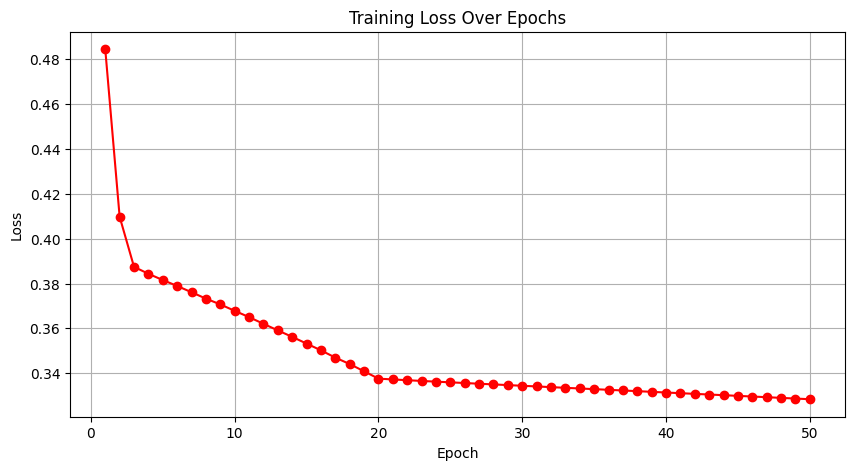

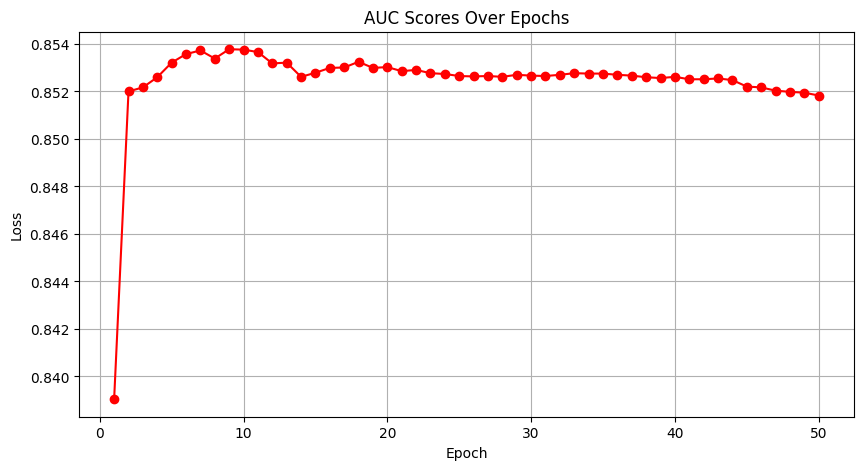

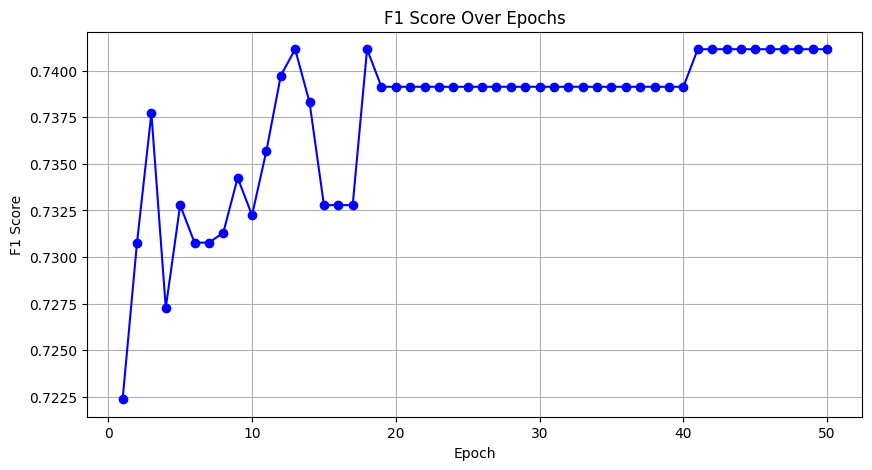

In [24]:
import matplotlib.pyplot as plt

# Plotting the Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), losses, marker='o', linestyle='-', color='r')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
plt.savefig('training_loss.jpg', format='jpg')
plt.close()

# Plotting the Auc Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), auc_scores, marker='o', linestyle='-', color='r')
plt.title('AUC Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
plt.savefig('auc_score.jpg', format='jpg')
plt.close()

# Plotting the F1 Score
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), f1_scores, marker='o', linestyle='-', color='b')
plt.title('F1 Score Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()
plt.savefig('f1_score.jpg', format='jpg')
plt.close()

## Discussion of Hypothesis and Results From Original Paper

This table is the result shown in the original paper:

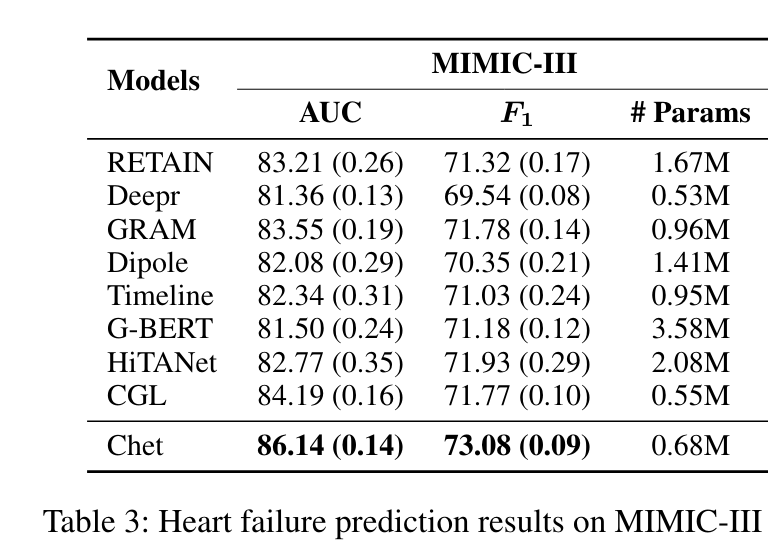

Taking result from our reproduction code, the highest AUC score and the F1-score we get is **85.37** and **74.11**.

Although we are not able to reproduce the result that the original paper mentioned, we can see that this GNN model with context-aware approach already outperforms other models as of 2022. Hence this draws a clear claim to our first hypothesis:
* Dynamic disease maps improve prediction accuracy more than static models.

However, by observing the plots we generated above, we can still see some problems:

1.   The AUC score converges very fast at the first 10 epochs, and the F-1 score converges after 20 epochs. Recall that for the first layer we used GRU to memorize the structure and add single head attenttion to the GNN layer, this indicates that the model are able to memorize the entire graph structure and predicts well after few epochs, so there is really no need to use 200 epochs mentioned in the original paper to train this model.
2.   The AUC score on the validation set has a long tail decreasing trend after 10 epochs. We conjecture that there is an overfit. Hence, we conduct the following experiment to varify our second hypothesis.



## Experiments beyond the original paper

To Verify the hypothesis 2, which is increasing the dropout rate in the model will improve its generalization on the validation set by reducing overfitting, we conduct the following experiment:
* Modifying the dropout rate to 0.2 (originally set to 0).
* Use 20 epochs to train the new model, and then compare its performance with the original model on the validation dataset.

See below code:

In [28]:
if __name__ == '__main__':
    seed = 6669
    dataset = 'mimic3'  # 'mimic3' or 'eicu'
    task = 'h'  # 'm' or 'h'
    use_cuda = True
    device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')

    code_size = 48
    graph_size = 32
    hidden_size = 150  # rnn hidden size
    t_attention_size = 32
    t_output_size = hidden_size
    batch_size = 32
    epochs = 20 # For the experiment

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # dataset_path = os.path.join('data', dataset, 'standard')
    dataset_path = '/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard'
    print(dataset_path)
    train_path = os.path.join(dataset_path, 'train')

    valid_path = os.path.join(dataset_path, 'valid')
    test_path = os.path.join(dataset_path, 'test')

    # dataset_path = '/content/drive/MyDrive/Colab Notebooks/Chet/data/mimic3/standard/code_adj.npz'

    code_adj = load_adj(dataset_path, device=device)
    code_num = len(code_adj)
    print('loading train data ...')
    train_data = EHRDataset(train_path, label=task, batch_size=batch_size, shuffle=True, device=device)
    print('loading valid data ...')
    valid_data = EHRDataset(valid_path, label=task, batch_size=batch_size, shuffle=False, device=device)
    print('loading test data ...')
    test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)

    test_historical = historical_hot(valid_data.code_x, code_num, valid_data.visit_lens)

    task_conf = {
        'm': {
            'dropout': 0.45,
            'output_size': code_num,
            'evaluate_fn': evaluate_codes,
            'lr': {
                'init_lr': 0.01,
                'milestones': [20, 30],
                'lrs': [1e-3, 1e-5]
            }
        },
        'h': {
            'dropout': 0.2,
            'output_size': 1,
            'evaluate_fn': evaluate_hf,
            'lr': {
                'init_lr': 0.01,
                'milestones': [2, 3, 20],
                'lrs': [1e-3, 1e-4, 1e-5]
            }
        }
    }
    output_size = task_conf[task]['output_size']
    activation = torch.nn.Sigmoid()
    loss_fn = torch.nn.BCELoss()
    evaluate_fn = task_conf[task]['evaluate_fn']
    dropout_rate = task_conf[task]['dropout']

    param_path = os.path.join('data', 'params', dataset, task)
    if not os.path.exists(param_path):
        os.makedirs(param_path)

    model = Model(code_num=code_num, code_size=code_size,
                  adj=code_adj, graph_size=graph_size, hidden_size=hidden_size, t_attention_size=t_attention_size,
                  t_output_size=t_output_size,
                  output_size=output_size, dropout_rate=dropout_rate, activation=activation).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    scheduler = MultiStepLRScheduler(optimizer, epochs, task_conf[task]['lr']['init_lr'],
                                     task_conf[task]['lr']['milestones'], task_conf[task]['lr']['lrs'])

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    losses = []
    f1_scores = []
    auc_scores = []

    for epoch in range(epochs):
        print('Epoch %d / %d:' % (epoch + 1, epochs))
        model.train()
        total_loss = 0.0
        total_num = 0
        steps = len(train_data)
        st = time.time()
        scheduler.step()

        for step in range(len(train_data)):
            optimizer.zero_grad()
            code_x, visit_lens, divided, y, neighbors = train_data[step]
            output = model(code_x, divided, neighbors, visit_lens).squeeze()
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * output_size * len(code_x)
            total_num += len(code_x)

            end_time = time.time()
            remaining_time = format_time((end_time - st) / (step + 1) * (steps - step - 1))
            print('\r    Step %d / %d, remaining time: %s, loss: %.4f'
                  % (step + 1, steps, remaining_time, total_loss / total_num), end='')

        train_data.on_epoch_end()
        et = time.time()
        time_cost = format_time(et - st)

        avg_loss = total_loss / total_num
        losses.append(avg_loss)

        print('\r    Step %d / %d, time cost: %s, loss: %.4f' % (steps, steps, time_cost, total_loss / total_num))
        valid_loss, auc_score_, f1_score_ = evaluate_fn(model, valid_data, loss_fn, output_size, test_historical)
        # torch.save(model.state_dict(), os.path.join(param_path, '%d.pt' % epoch))

        auc_scores.append(auc_score_)
        f1_scores.append(f1_score_)

        if (epoch + 1) % 10 == 0:
          save_path = os.path.join(param_path, f'model-experiment-{epoch+1}.pt')
          torch.save(model.state_dict(), save_path)
          # print(f'Model saved to {save_path}')

/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard
loading train data ...
loading valid data ...
loading test data ...
721085
Epoch 1 / 20:
    Step 188 / 188, time cost: 1m30.9s, loss: 0.4921
    Evaluation: loss: 0.4879 --- auc: 0.8400 --- f1_score: 0.7258
Epoch 2 / 20:
    Step 188 / 188, time cost: 1m29.3s, loss: 0.4162
    Evaluation: loss: 0.4749 --- auc: 0.8435 --- f1_score: 0.7104
Epoch 3 / 20:
    Step 188 / 188, time cost: 1m49.8s, loss: 0.3927
    Evaluation: loss: 0.4772 --- auc: 0.8433 --- f1_score: 0.7104
Epoch 4 / 20:
    Step 188 / 188, time cost: 1m50.0s, loss: 0.3879
    Evaluation: loss: 0.4821 --- auc: 0.8431 --- f1_score: 0.7072
Epoch 5 / 20:
    Step 188 / 188, time cost: 1m30.6s, loss: 0.3868
    Evaluation: loss: 0.4839 --- auc: 0.8427 --- f1_score: 0.7072
Epoch 6 / 20:
    Step 188 / 188, time cost: 1m35.9s, loss: 0.3836
    Evaluation: loss: 0.4851 --- auc: 0.8422 --- f1_score: 0.7072
Epoch 7 / 20:
    Step 188 / 188, time cost: 1m37.1s, loss: 0.3804
  

In [29]:
!cp -r  /content/data /content/drive/My\ Drive/

By comparing the result we set the dropout rate to 0.2, both the auc score and the f1 score has decreased by 2%. Hence our hypothesis 2 is wrong, which indicates we simply need to run more iterations when training this model.

## Ablation Study

To further analyze the effectiveness of each module in Chet,
we also compare the varient of the model:

* We remove the dynamic part of GNN in our model. Instead of using dynamic subgraphs , we adopt a universal embedding matrix for all diseases and use the global combination graph $A$ for the aggregation of diagnoses and neighbors. We project the universal embeddings into the dimension $p$ with a fully connected layer to replace the embeddings $R$ for unrelated disease.

Here is the inference result of this ablation study model after running 50 epochs:


In [33]:
# Load the model
model_path = '/content/drive/MyDrive/data/params/mimic3/h/ablation-model-50.pt'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load the dataset
test_dataset_path = '/content/drive/MyDrive/CS598HLO/Chet/data/mimic3/standard/'
test_path = os.path.join(test_dataset_path, 'test')
test_data = EHRDataset(test_path, label=task, batch_size=batch_size, shuffle=False, device=device)

# Run evaluation
evaluate_hf(model, valid_data, loss_fn, task_conf[task]['output_size'], historical=test_historical)

    Evaluation: loss: 0.4915 --- auc: 0.8406 --- f1_score: 0.6964


(0.4914717061282655, 0.8405975455508837, 0.6963788300835656)

We can see that there is a drop on both the auc score and the f1 score.

Therefore, this ablation study validates the effectiveness of dynamic learning for the disease combination graph.

# Discussion




First and foremost, we can answer the so far most important question towards this paper: **Yes, this paper is reproducible.**

Although we didn't get to the best result mentioned in the original paper, we succeeded to reproduce a overall good result, which shows that the approach of constructing dynamic graphs among patient's previous visited record and the overall disease types is indeed a correct direction.

The easy part of this project is the intuition to understand their model architecture: In the original paper, they only use the GRU, single-head attention(with matrix computation), and GNN structure.

The hard part, however, is their way to preprocess code, which is hard to follow. They combined the MIMIC-III dataset with three different graph construction methods, which makes the logic really hard to follow without the visualization.

Our recommendation to others working in the area for improving reproducibility is that: please maintain good documentation of your code. Taking the original code base for example, the readme file only shows two step: run the preprocessing script, and then run the training script. The direct result come to us is that we spent a lot of time to understand the file structure when reproducing this paper, hence increase the difficulty to improve future results beyond this paper.

Overall, this is a good paper which shows the potential in understanding the graph neural network field. One remark is that this paper's implemented model will be powerful after we enlarge the dataset. Specifically, we still need more high quality patient's visiting record to let the model learn the connections between the patient and the typical disease.

In [ ]:
!pip install nbconvert


In [34]:
!jupyter nbconvert --to html '/content/drive/MyDrive/Colab Notebooks/Team35.ipynb'


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Team35.ipynb to html
[NbConvertApp] Writing 1117203 bytes to /content/drive/MyDrive/Colab Notebooks/Team35.html


In [35]:
from google.colab import files
files.download('/content/drive/MyDrive/Colab Notebooks/Team35.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>